
# Run all cells

Look for instructions below


In [ ]:
!apt-get install clang-9
!git clone https://github.com/RumblingTurtle/SrdPy.git
!pip install git+https://github.com/rdeits/meshcat-python.git@master
!pip install ./SrdPy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  binfmt-support libclang-common-9-dev libclang-cpp9 libclang1-9 libffi-dev
  libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev llvm-9-runtime
  llvm-9-tools python-chardet python-pkg-resources python-pygments python-yaml
  python3-pkg-resources python3-pygments python3-yaml
Suggested packages:
  clang-9-doc libomp-9-doc llvm-9-doc python-setuptools ttf-bitstream-vera
  python3-setuptools
The following NEW packages will be installed:
  binfmt-support clang-9 libclang-common-9-dev libclang-cpp9 libclang1-9
  libffi-dev libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev
  llvm-9-runtime llvm-9-tools python-chardet python-pkg-resources
  python-pygments python-yaml python3-pkg-resources python3-

In [ ]:
from SrdPy.URDFUtils import getLinkArrayFromURDF

from SrdPy.TableGenerators import generateConstraiedLinearModelTable
from SrdPy.TableGenerators import generateLinearModelTable
from SrdPy.LinksAndJoints import *
from SrdPy.Handlers import *
from SrdPy.InverseKinematics import *
from SrdPy.SymbolicUtils import *
from SrdPy.Loggers import *
from SrdPy.DynamicSolvers import *
from SrdPy.Controllers import *

from SrdPy.Visuals import Visualizer
from SrdPy import SymbolicEngine
from SrdPy import plotGeneric
from copy import deepcopy
from casadi import *

from SrdPy.TableGenerators import *
from SrdPy import Chain
from SrdPy import Profiler
import numpy as np
from scipy.integrate import solve_ivp
import os

In [13]:
p = Profiler()
iiwaLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
iiwaChain = Chain(iiwaLinks)


print(iiwaChain)
initialPosition = np.array([0.1701584,  -0.07586424,  0.42323069, -0.41380217,  0.01195943,  0.07095069,
  0.])

# CHANGE INITIAL POSITION HERE
# Data must produce a smooth condition number graph (with small maximum value), and a constant rank of 2.
initialPosition = np.array([0.5,  -0.2,  0.1, -0.4,  0.3,  0.7, 0.9])

blank_chain = deepcopy(iiwaChain)
blank_chain.update(initialPosition)

engine = SymbolicEngine(iiwaChain.linkArray)

deriveJacobiansForlinkArray(engine)
H = deriveJSIM(engine)

iN, dH = deriveGeneralizedInertialForces_dH(engine, H)
g = deriveGeneralizedGravitationalForces(engine)
d = deriveGeneralizedDissipativeForcesUniform(engine, 1)
T = deriveControlMap(engine)


description_gen_coord_model = generateDynamicsGeneralizedCoordinatesModel(engine,
                                                                          H=H,
                                                                          c=(iN + g + d),
                                                                          T=T,
                                                                          functionName_H="g_dynamics_H",
                                                                          functionName_c="g_dynamics_c",
                                                                          functionName_T="g_dynamics_T",
                                                                          casadi_cCodeFilename="g_dynamics_generalized_coordinates",
                                                                          path="./iiwa/Dynamics")

handlerGeneralizedCoordinatesModel = GeneralizedCoordinatesModelHandler(description_gen_coord_model)

description_linearization = generateDynamicsLinearization(engine,
                                                          H=H,
                                                          c=(iN + g + d),
                                                          T=T,
                                                          functionName_A="g_linearization_A",
                                                          functionName_B="g_linearization_B",
                                                          functionName_c="g_linearization_c",
                                                          casadi_cCodeFilename="g_dynamics_linearization",
                                                          path="./iiwa/Linearization")
                                                          
handlerLinearizedModel = LinearizedModelHandler(description_linearization)

constraint6 = engine.links["iiwa_link_6"].absoluteFollower[0]

task = constraint6[:2]
print("task size is: ", task.size)


description_IK = generateSecondDerivativeJacobians(engine,
                                                task=task,
                                                functionName_Task="g_InverseKinematics_Task",
                                                functionName_TaskJacobian="g_InverseKinematics_TaskJacobian",
                                                functionName_TaskJacobianDerivative="g_InverseKinematics_TaskJacobian_derivative",
                                                casadi_cCodeFilename="g_InverseKinematics",
                                                path="./iiwa/InverseKinematics")

ikModelHandler = IKModelHandler(description_IK, engine.dof, task.shape[0])

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 

Loaded existing .so at ./iiwa/Dynamics
Loaded existing .so at ./iiwa/Linearization
task size is:  2
Starting writing function for the g_InverseKinematics_Task
Starting writing function for the g_InverseKinematics_Task task jacobian
Starting writing function for the derivative of g_InverseKinematics_Task
Generated C code!


Calculating  0.0%
Calculating  0.0%
Calculating  1.0%
Calculating  2.0%
Calculating  3.0%
Calculating  4.0%
Calculating  5.0%
Calculating  6.0%
Calculating  7.0%
Calculating  8.0%
Calculating  9.0%
Calculating  10.0%
Calculating  11.0%
Calculating  12.0%
Calculating  13.0%
Calculating  14.0%
Calculating  15.0%
Calculating  16.0%
Calculating  17.0%
Calculating  18.0%
Calculating  19.0%
Calculating  20.0%
Calculating  21.0%
Calculating  22.0%
Calculating  23.0%
Calculating  24.0%
Calculating  25.0%
Calculating  26.0%
Calculating  27.0%
Calculating  28.0%
Calculating  29.0%
Calculating  30.0%
Calculating  31.0%
Calculating  32.0%
Calculating  33.0%
Calculating  34.0%
Calculating  35.0%
Calculating  36.0%
Calculating  37.0%
Calculating  38.0%
Calculating  39.0%
Calculating  40.0%
Calculating  41.0%
Calculating  42.0%
Calculating  43.0%
Calculating  44.0%
Calculating  45.0%
Calculating  46.0%
Calculating  47.0%
Calculating  48.0%
Calculating  49.0%
Calculating  50.0%
Calculating  51.0%
Calc

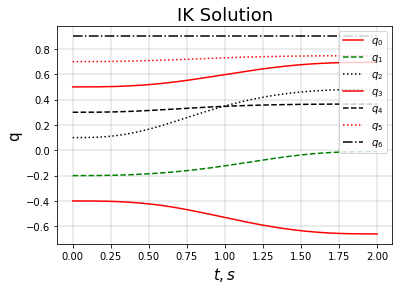

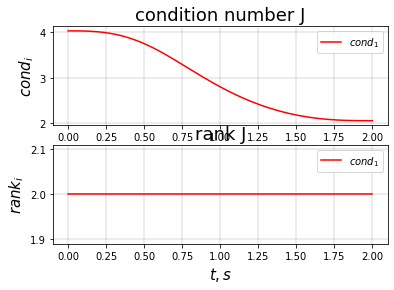

In [14]:
IC_task = ikModelHandler.getTask(initialPosition)

task_1 = np.array([[0.1],  [0.3]])
# task_2 = np.array([[0.3],  [0.3]])
# task_3 = np.array([[0.3],  [0.1]])

# zeroOrderDerivativeNodes = np.hstack((IC_task, task_1, task_2, task_3))
zeroOrderDerivativeNodes = np.hstack((IC_task, task_1))

firstOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

secondOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

timeOfOneStage = 2
timeEnd = (len(zeroOrderDerivativeNodes[1]) - 1) * timeOfOneStage + 1
nodeTimes = np.arange(start=0, stop=timeEnd, step=timeOfOneStage)

handlerIK_taskSplines = IKtaskSplinesHandler(nodeTimes,
                                                zeroOrderDerivativeNodes, 
                                                firstOrderDerivativeNodes,
                                                secondOrderDerivativeNodes)

timeTable = np.arange(handlerIK_taskSplines.timeStart, handlerIK_taskSplines.timeExpiration + 0.01, 0.01)

IKTable = generateIKTable(ikModelHandler, handlerIK_taskSplines, initialPosition, timeTable, method="lsqnonlin")
plotIKTable(ikModelHandler, timeTable, IKTable)

ikSolutionHandler = IKSolutionHandler(ikModelHandler, handlerIK_taskSplines, timeTable, IKTable, "linear")

tf = ikSolutionHandler.timeExpiration

n = handlerGeneralizedCoordinatesModel.dofConfigurationSpaceRobot

A_table, B_table, c_table, x_table, u_table, dx_table = generateLinearModelTable(handlerGeneralizedCoordinatesModel,handlerLinearizedModel,ikSolutionHandler,timeTable)


# Task

 

1. Implement control, but state observer (x can't be used by the controller, but $y = Cx$ can be)
2. Simulate the system with the observer and the controller
3. Simulate from different initial positions



### Deriving the dynamics of observer and controller
We have
\begin{equation}
\begin{cases}
\dot x = Ax+Bu+c\\
\dot{\hat x} = Ax+Bu + L(y - C \hat x) + c\\
y=Cx\\
u=-K (\hat x-x^*)+u^*
\end{cases}
\end{equation}
<br>
Collecting $\dot x$ and $\hat x$ we get:

<br>
\begin{equation}
\begin{bmatrix}
\dot x \\
\hat x
\end{bmatrix}
=
\begin{bmatrix}
A & -BK \\
LC & A-BK-LC
\end{bmatrix}
\begin{bmatrix}
x \\
\hat x
\end{bmatrix}
+
\begin{bmatrix}
BKx^*+Bu^*+c \\
BKx^*+Bu^*+c
\end{bmatrix}
\end{equation}
<br>

Let's introduce an abuse of notation
\begin{equation}
AA=
\begin{bmatrix}
A & -BK \\
LC & A-BK-LC
\end{bmatrix}
\end{equation}

<br>

\begin{equation}
cc=
\begin{bmatrix}
BKx^*+Bu^*+c \\
BKx^*+Bu^*+c
\end{bmatrix}
\end{equation}

Now we simulate the system with the observer and the controller

In [ ]:
# given the observer and the controller variables
# this function applies the formulas above and returns the AA and cc tables

def my_generateCloseLoopTable(A_table, B_table, C_table, K_Table, L_table, c_table, x_d_table, u_d_table):
    AA_table = []
    for i in range(count):
      AA_table.append(np.vstack((
                          np.hstack((A_table[i], -B_table[i].dot(K_table[i]))),
                          np.hstack((L_table[i].dot(C_table[i]), A_table[i]-B_table[i].dot(K_table[i])-L_table[i].dot(C_table[i])))
                      ))
                     )

    cc_table = []
    for i in range(count):
      cc_table.append(np.hstack((
                          B_table[i].dot(K_table[i]).dot(x_d_table[i]) + B_table[i].dot(u_d_table[i]) + c_table[i],
                          B_table[i].dot(K_table[i]).dot(x_d_table[i]) + B_table[i].dot(u_d_table[i]) + c_table[i]
                      ))
                     )
    return np.array(AA_table), np.array(cc_table)

In [ ]:
# this function turns every matrix in a table of matrices and returns the modified table
def trn_table(t):
  ret = []
  for i in t:
    ret.append(i.T)
  return np.array(ret)

In [ ]:
from control import lqr

# this function generate solves the LQR multiple times and returns a table of resutls
def my_generateLQRTable(A_table, B_table, Q_table, R_table):
    K_table = []
    
    for i in range(A_table.shape[0]):
        K, _, _ =  lqr(A_table[i], B_table[i], Q_table[i], R_table[i])
        K_table.append(K)

    return np.array(K_table)

In [15]:
count = A_table.shape[0]

C = np.concatenate((np.eye(n), np.zeros((n, n))), axis=1) # y = C*x
C_table = np.array(count * [C])

Q = 0.1 * np.eye(2 * n)
R = 10 * np.eye(handlerGeneralizedCoordinatesModel.dofControl)

# Controller gains
K_table = my_generateLQRTable(A_table, B_table, np.tile(Q, [count, 1, 1]), np.tile(R, [count, 1, 1]))

# Observer gains
L_table = trn_table(my_generateLQRTable(trn_table(A_table), trn_table(C_table), np.tile(Q, [count, 1, 1]), np.tile(R, [count, 1, 1])))

# Generate closed-loop system
AA_table, cc_table = my_generateCloseLoopTable(A_table, B_table, C_table, K_table, L_table, c_table, x_table, u_table)

# Initial positions, initially, the observed values are the same as the actual values
x0 = np.hstack((initialPosition, np.zeros(n), initialPosition, np.zeros(n)))

# Now we have everything we needed for simulation
# from sympy import *
# display(Matrix(x0))

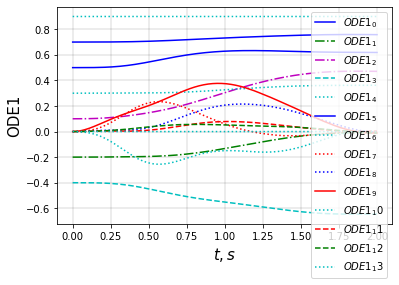

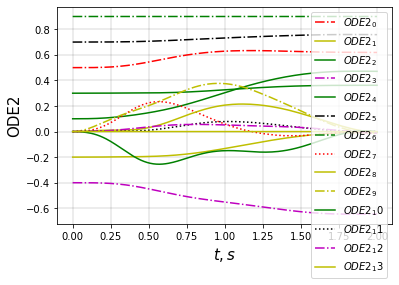

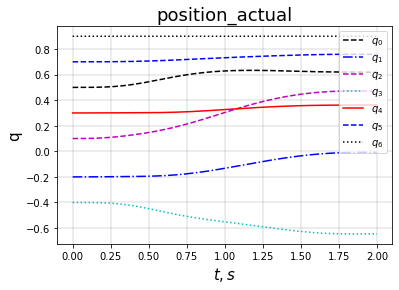

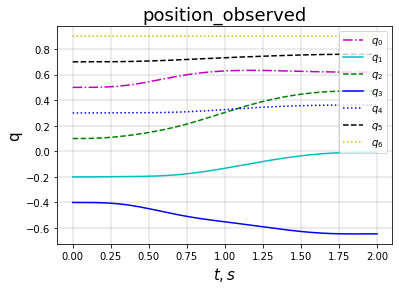

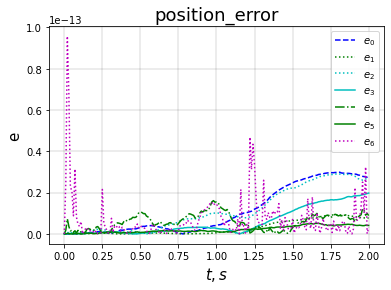

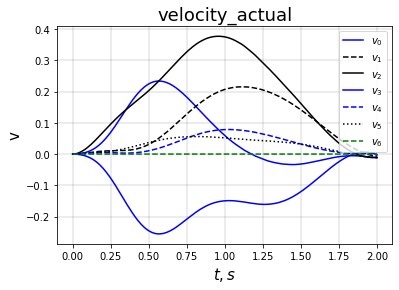

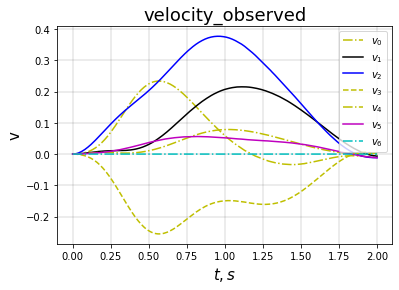

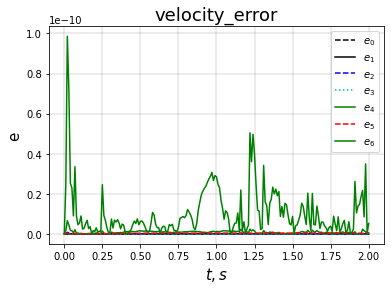

In [16]:
# Simulation
ode_fnc_handle = ClosedLoopLinearSystemOdeFunctionHandler(AA_table, cc_table, timeTable)
sol = solve_ivp(ode_fnc_handle, [0, tf], x0, t_eval=timeTable,method="RK45")

# plot graphs
time_table_0 = sol.t
solution_tape_1 = sol.y[:n*2].T # Actual states
solution_tape_2 = sol.y[n*2:].T # Observed states

plotGeneric(time_table_0, solution_tape_1, figureTitle="", ylabel="ODE1")
plotGeneric(time_table_0, solution_tape_2, figureTitle="", ylabel="ODE2")

plotGeneric(timeTable, solution_tape_1[:, :n], figureTitle="position_actual", ylabel="q", plot=True)
plotGeneric(timeTable, solution_tape_2[:, :n], figureTitle="position_observed", ylabel="q", plot=True)

plotGeneric(timeTable, abs(solution_tape_1[:, :n] - solution_tape_2[:, :n]), figureTitle="position_error", ylabel="e", plot=True)

plotGeneric(timeTable, solution_tape_1[:, n:2*n], figureTitle="velocity_actual", ylabel="v", plot=True)
plotGeneric(timeTable, solution_tape_2[:, n:2*n], figureTitle="velocity_observed", ylabel="v", plot=True)

plotGeneric(timeTable, abs(solution_tape_1[:, n:2*n] - solution_tape_2[:, n:2*n]), figureTitle="velocity_error", ylabel="e", plot=True)

with open('anim_array.npy', 'wb') as f:
    np.save(f, solution_tape_2[:,:n])

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 



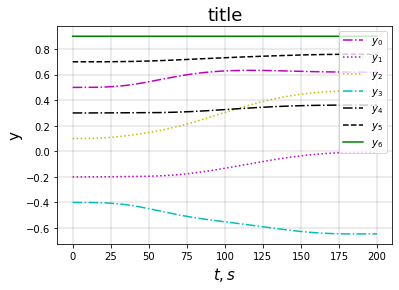

You can open the visualizer by visiting the following URL:
http://89e5970347ff.ngrok.io/static/
No mesh: Ground


In [17]:
chainLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
chain = Chain(chainLinks)

print(chain)
blank_chain = deepcopy(chain)
blank_chain.update(initialPosition)
with open('anim_array.npy', 'rb') as f:
    q = np.load(f)

blank_chain.update(q[0])
plotGeneric(np.arange(q.shape[0]),q,plot=True)
vis = Visualizer()
vis.animate(blank_chain,q,framerate=0.1,showMeshes=True)

Click the link above to see animation ^^^